In [13]:
import datetime # для того, чтобы посчитать время работы
import numpy as np # вычисления
from matplotlib import  pyplot as plt # графики
import matplotlib.patches as patches
import matplotlib.animation

In [14]:
def chebishev_polynom(n, x):
    if n == 0:
        # если n = 0, возвращаем единичный вектор; T(0, x) = 1
        return np.ones(len(x))
    elif n == 1:
        # елси n = 1, возвращаем исходный вектор; T(1, x) = x
        return x
    else:
        # иначе T(n, x) = 2*T(n-1, x) - T(n-2, x)
        return 2 * x * chebishev_polynom(n - 1, x) - chebishev_polynom(n - 2, x)

In [15]:
def make_A_b(filename, N):
    data = np.loadtxt(filename, dtype=float)
    
    # изначально данные в формате 
    # [X1, Y1],
    # [X2, Y2],
    # Поэтому, мы можем просто транспонировать и получить данные в виде
    # [X1, X2, X3 ..],
    # [Y1, Y2, Y3 ..]
    
    data = data.T 
    
    # сделаем первую строку матрицы A
    A = np.array([chebishev_polynom(0, data[0])])
    
    # и заполним его до ширины N
    for j in range(1, N + 1):
        A = np.vstack((A, chebishev_polynom(j, data[0]))) # vstack - добавить вектор снизу к исходной матрицу
    
    # теперь мы получили матрицу n x m
    
    A = A.T # и в конце транспонируем обратно, чтобы получить m x n
    
    b = data[1] # b - просто вектор игриков 
    return A, b

In [16]:
def NU(A, b): # метод НУ
    # A.T * A * x = A.T * b
    
    A_transp = A.T
    
    AtA = np.dot(A_transp, A)
    Atb = np.dot(A_transp, b)
    
    coeffs = np.linalg.solve(AtA, Atb) # рассчитываем коффициенты
    
    NRSME = np.sqrt(np.sum((np.dot(A, coeffs) - b)**2) / len(A)) / np.max(np.abs(b)) # считаем погрешность
    cond = np.linalg.cond(AtA) # считаем собственное число матрицы AtA
    
    return coeffs, NRSME, cond

In [17]:
def QR_rotation(A, b):
    # через вращение гивенса
    Q, R = np.linalg.qr(A)
    m_length, n_length = A.shape
    Q = np.identity(m_length)
    R = A.copy()
    

    for j in range(n_length): # цикл по каждому столбцу
        
        # находим главный элемент
        if j == 0:
            # в первом столбце находим максимальное по модулю значение, находим индекс его строки
            max_elem_index = np.argmax(np.abs(A[:,j]))

            # меняем местами строки, так чтобы максимальный элемент оказался сверху
            R[j], R[max_elem_index] = R[max_elem_index].copy(), R[j].copy()
            
            # и дублируем это в b
            b[j], b[max_elem_index] = b[max_elem_index].copy(), b[j].copy()


        for i in range(j + 1, m_length): # цикл по каждой строке, где строка начинается с номера столбца + 1
            if R[i, j] != 0:
                r = np.sqrt(R[j, j]**2 + R[i, j]**2) # значеменатель
                c = R[j, j] / r # cos
                s = - R[i, j] / r # sin
                
                i_ = R[i,:].copy() # копируем i-ю строку
                j_ = R[j,:].copy() # копируем j-ю строку
                R[i,:] = i_ * c + j_ * s # пересчитываем значения в i-й строке
                R[j,:] = i_ * s - j_ * c # пересчитываем значения в j-й строке
                R[i, j] = 0 # зануляем элемент вокруг которого и происходит вращение

                i_ = Q[:,i].copy() # копируем i-й столбец
                j_ = Q[:,j].copy() # копируем j-й столбец
                Q[:,i] = i_ * c + j_ * s # пересчитываем значения в i-м столбце
                Q[:,j] = i_ * s - j_ * c # пересчитываем значения в j-м столбце
                
    R = R[:n_length,:] # Обрезаем строки ниже n (там и так нули, приведем к верхнетреугольной)
    Q = Q[:,:n_length] # Обрезаем столбцы левее n
    
    coeffs = np.dot(np.linalg.inv(R), np.dot(Q.T, b))
    NRSME = np.sqrt(np.sum((np.dot(A, coeffs) - b)**2) / len(A)) / np.max(np.abs(b))
    cond = np.linalg.cond(A) # считаем число обусловленности для A
    
    return coeffs, NRSME, cond

In [22]:
def plot_graphics(x, y_data, y_approx, n, n_data):
    fig = plt.figure(figsize=(12,8), frameon=True)
    plt.style.use('ggplot')
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['font.size'] = 17
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    ax = fig.add_subplot(111)    

    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.set(facecolor='w')
    ax.grid('axis = "both"', color = 'gray')

    ax.set_xlabel('$x$', labelpad = -10)
    ax.set_ylabel('$y$', rotation = 0, labelpad = 20)

    ax.plot(x, y_data, color = 'blue', linestyle = '-', linewidth = 3, label=f'Данные № {n_data}')
    ax.plot(x, y_approx, color = 'red', linestyle = '-', linewidth = 2, label = 'Приближение при N = ' + str(n))
    ax.legend(loc=4)

    plt.show()

In [23]:
A, b = make_A_b('data_3.txt', 3)

In [24]:
NU(A, b)

(array([ 1254.64010902, -6914.87295909,  1253.87365177, -3381.79966399]),
 0.000669000648587737,
 84896289.41212381)

In [25]:
QR_rotation(A, b)

(array([ 1254.64010852, -6914.87295646,  1253.87365127, -3381.79966314]),
 0.0006690006485877366,
 9213.918243013482)

In [36]:
# Рассчитаем таблицу для NU
filename = 'data_3.txt'
for n in range(0, 11):
    print('N =', n)
    start_time = datetime.datetime.now()
    A, b = make_A_b(filename, n)
    _, NRSME, cond = NU(A, b)
    print('Число обусловленности:')
    print('%.2E' % cond)
    print('Погрешность:')
    print('%.2E' % NRSME)
    print('Время выполнения:')
    print((datetime.datetime.now() - start_time).total_seconds())
    print()

N = 0
Число обусловленности:
1.00E+00
Погрешность:
2.91E-01
Время выполнения:
0.00279

N = 1
Число обусловленности:
3.42E+02
Погрешность:
6.63E-03
Время выполнения:
0.002495

N = 2
Число обусловленности:
1.48E+05
Погрешность:
2.94E-03
Время выполнения:
0.002033

N = 3
Число обусловленности:
8.49E+07
Погрешность:
6.69E-04
Время выполнения:
0.002143

N = 4
Число обусловленности:
4.02E+10
Погрешность:
6.64E-04
Время выполнения:
0.002298

N = 5
Число обусловленности:
2.37E+13
Погрешность:
6.25E-04
Время выполнения:
0.00259

N = 6
Число обусловленности:
1.27E+16
Погрешность:
4.84E-04
Время выполнения:
0.00314

N = 7
Число обусловленности:
2.88E+17
Погрешность:
4.95E-04
Время выполнения:
0.003003

N = 8
Число обусловленности:
1.20E+18
Погрешность:
4.64E-04
Время выполнения:
0.003821

N = 9
Число обусловленности:
3.57E+17
Погрешность:
4.98E-04
Время выполнения:
0.005695

N = 10
Число обусловленности:
1.14E+18
Погрешность:
4.60E-04
Время выполнения:
0.007123



In [37]:
# Рассчитаем таблицу для QR
filename = 'data_3.txt'
for n in range(0, 11):
    print('N =', n)
    start_time = datetime.datetime.now()
    A, b = make_A_b(filename, n)
    _, NRSME, cond = QR_rotation(A, b)
    print('Число обусловленности:')
    print('%.2E' % cond)
    print('Погрешность:')
    print('%.2E' % NRSME)
    print('Время выполнения:')
    print((datetime.datetime.now() - start_time).total_seconds())
    print()

N = 0
Число обусловленности:
1.00E+00
Погрешность:
2.91E-01
Время выполнения:
6.205982

N = 1
Число обусловленности:
1.85E+01
Погрешность:
6.63E-03
Время выполнения:
11.604306

N = 2
Число обусловленности:
3.84E+02
Погрешность:
2.94E-03
Время выполнения:
18.154751

N = 3
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/develop_user/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3357102/39224570.py", line 7, in <module>
    _, NRSME, cond = QR_rotation(A, b)
  File "/tmp/ipykernel_3357102/4190333315.py", line -1, in QR_rotation
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/develop_user/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/develop_user/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1112, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/develop_user/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1006, in structured_traceback
    return VerboseTB.s

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


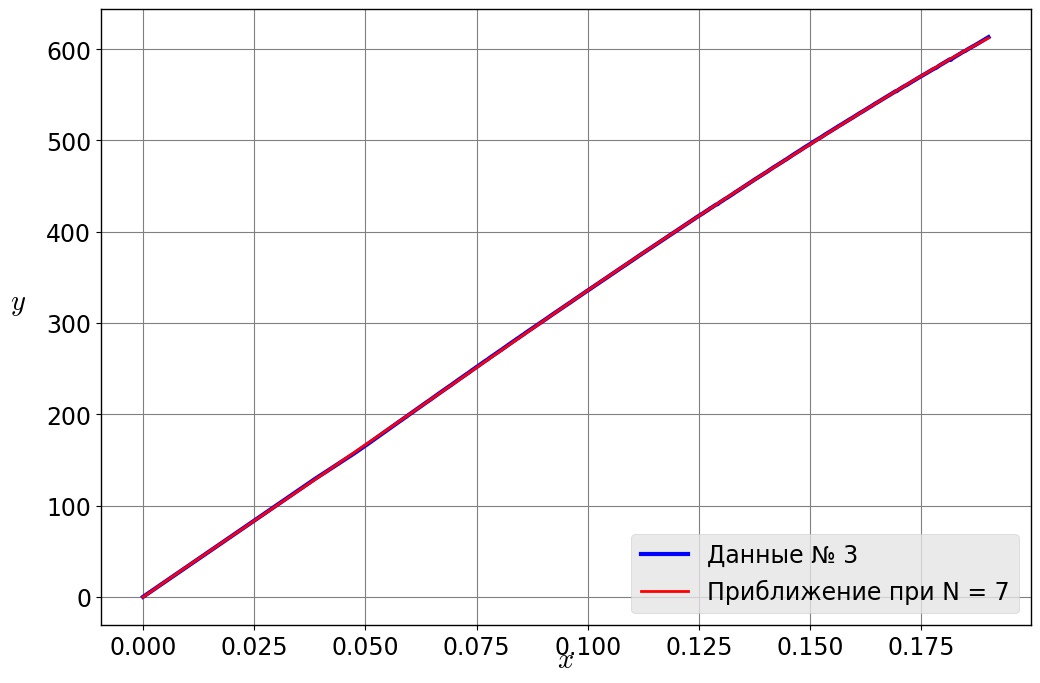

In [38]:
# строим графики

n_data = 3 # какие данные

filename = f'data_{n_data}.txt'
n = 7 # n полинома

x = np.loadtxt(filename, dtype=float).T[0]
A, b = make_A_b(filename, n)
coeffs, _, _ = NU(A, b)
b_approx = np.dot(A, coeffs)

plot_graphics(x, b, b_approx, n, n_data)